# Training LSTM model on Bangla books

First we import necessary packages for our project

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

Set `seaborn` for better data visualization

In [2]:
sns.set()

## Preparing Dataset

Initialize the project root, data, and model related directories. `processed_data` directory contains selected books from renowned authors only.

In [3]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]

data_dir = project_root / 'processed_data/'
model_home = project_root / 'models/bn_lstm'
plot_dir = model_home / 'plots'

os.makedirs(model_home, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

Get list of files in the data directory

In [4]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [5]:
random.shuffle(filenames)
filenames = filenames[:50]

Save filenames to resume training on these later

In [6]:
with open(model_home / 'filenames.pickle', 'wb') as file:
    pickle.dump(filenames, file=file)

Load filenames from pickle file

In [7]:
with open(model_home / 'filenames.pickle', 'rb') as file:
    filenames = pickle.load(file)

Split the files for training and testing. We are keeping 20% for testing and 80% for training.

In [8]:
test_split = 0.2
test_size = int(len(filenames) * test_split)
train_filenames = filenames[:-test_size]
test_filenames = filenames[-test_size:]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [9]:
def create_tokenizer(files, max_words):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<oov>")
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace new lines with space
            tokenizer.fit_on_texts([lines])

    # save the tokenizer in model dir
    with open(model_home / f'tokenizer_{max_words}_words.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save word_index as json file
    with open(model_home / 'word_index.json', 'w') as handle:
        json.dump(tokenizer.word_index, handle, ensure_ascii=False) # write unicode characters

    return tokenizer

Define max words and max sequence length

In [10]:
max_words = 10000
max_seq_len = 200
embed_dim = 256

Now create the tokenizer and fit on training files

In [11]:
tokenizer = create_tokenizer(train_filenames, max_words)

100%|████████████████████████████████████████| 40/40 [00:02<00:00, 13.39it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [12]:
def create_dataset(tokenizer, files, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace all new lines with spaces
            token_list = tokenizer.texts_to_sequences([lines])

            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [13]:
X_train, y_train = create_dataset(tokenizer, train_filenames, max_seq_len)
X_test, y_test = create_dataset(tokenizer, test_filenames, max_seq_len)

100%|████████████████████████████████████████| 10/10 [00:02<00:00,  4.47it/s]


## Creating and Training LSTM Models

### Implement an embedding layer

Create two seperate embedding layers: one for tokens and one for token index (positions)

In [14]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    """
    A custom token and position embedding layer
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

`create_model()` returns a model with `no_of_lstm_layers` LSTM layers each with `no_of_units` units and `dropout_rate` dropout. We are compiling the model with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [15]:
def create_model(no_of_lstm_layers, no_of_units, dropout_rate):
    """
    Creates model with no of lstm layers, no of units and dropout rate in each layer
    """
    inputs = tf.keras.layers.Input(shape=(max_seq_len - 1,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(max_seq_len, max_words + 1, embed_dim)
    x = embedding_layer(inputs)

    # LSTM layers
    for i in range(no_of_lstm_layers - 1):
        x = tf.keras.layers.LSTM(no_of_units, return_sequences=True, dropout=dropout_rate)(x)
    x = tf.keras.layers.LSTM(no_of_units, dropout=dropout_rate)(x)

    outputs = tf.keras.layers.Dense(max_words + 1, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
    return model

We also need to create a plot to visualize training vs validation accuracy and loss. `create_plot()` creates a plot from history object with a title

In [16]:
def create_plot(history, title):
    """
    Creates plot from history, history object must have
    sparse_categorical_accuracy and loss for both training and validation dataset
    """
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_accuracy.png'), dpi=fig.dpi)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_loss.png'), dpi=fig.dpi)

We set callback `EarlyStopping` that monitors `val_loss` for 5 epochs and stops training if it does not improve. It prevents the model from overfitting.

In [17]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=0,
                                             patience=5,
                                             mode='auto')

`get_best_model()` takes a list of parameter and finds the best model parameter that has the best test set accuracy. Each parameter need to be defined as a tuple of three values - no of LSTM layers, no of units in each layer and dropout rate. It also saves the models in a directory `models/model_lstm/model-<no of layers>-<no of units>/model`, plots are saved in `models/model_lstm/plots/`.

In [18]:
def get_best_model(params):
    """Returns the trained model with the best model parameter"""
    best_model = None
    best_model_accuracy = 0.0
    best_model_param = None
    
    for param in params:
        assert len(param) == 3 # must have three items
        model_title = f"model-{param[0]}-{param[1]}"
        plot_title = f"Model with {param[0]} {param[1]} units LSTM layers"
        print(f"Training {plot_title}")
        
        model = create_model(param[0], param[1], param[2])
        # create model and its checkpoint directory
        model_dir = model_home / model_title
        
        # train and save the model
        history = model.fit(X_train, y_train,
                            validation_split=0.2,
                            epochs=20,
                            batch_size=1024,
                            callbacks=[earlystopping])
        model.save(model_dir)
        
        # create, show and save a plot from history
        create_plot(history, plot_title)
        accuracy = model.evaluate(X_test, y_test)[1]
        print(f"Model accuracy: {accuracy}")
        
        if accuracy > best_model_accuracy:
            best_model = model
            best_model_accuracy = accuracy
            best_model_param = param
        
        # save memory by deleting model and history
        del model
        del history
    return best_model, best_model_param

We create three model parameters and use `get_best_model()` function to find the best model.

Training Model with 2 150 units LSTM layers


2022-04-16 19:44:31.618506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:44:31.732493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:44:31.732844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 19:44:31.734990: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/20


2022-04-16 19:44:43.086072: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1098/1098 [==============================] - 349s 309ms/step - loss: 7.1014 - sparse_categorical_accuracy: 0.1186 - val_loss: 7.1929 - val_sparse_categorical_accuracy: 0.1063
Epoch 2/20
1098/1098 [==============================] - 336s 306ms/step - loss: 6.7192 - sparse_categorical_accuracy: 0.1262 - val_loss: 6.9585 - val_sparse_categorical_accuracy: 0.1160
Epoch 3/20
1098/1098 [==============================] - 337s 307ms/step - loss: 6.3580 - sparse_categorical_accuracy: 0.1367 - val_loss: 6.7510 - val_sparse_categorical_accuracy: 0.1253
Epoch 4/20
1098/1098 [==============================] - 334s 304ms/step - loss: 6.0939 - sparse_categorical_accuracy: 0.1445 - val_loss: 6.6321 - val_sparse_categorical_accuracy: 0.1319
Epoch 5/20
1098/1098 [==============================] - 334s 304ms/step - loss: 5.8899 - sparse_categorical_accuracy: 0.1517 - val_loss: 6.5406 - val_sparse_categorical_accuracy: 0.1364
Epoch 6/20
1098/1098 [==============================] - 334s 304ms/step - loss: 5

2022-04-16 21:30:54.743033: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


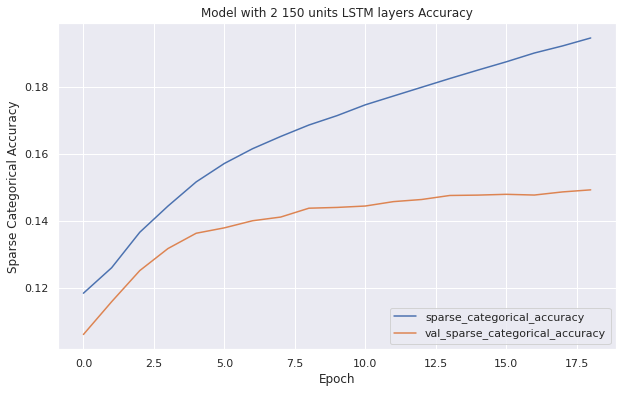

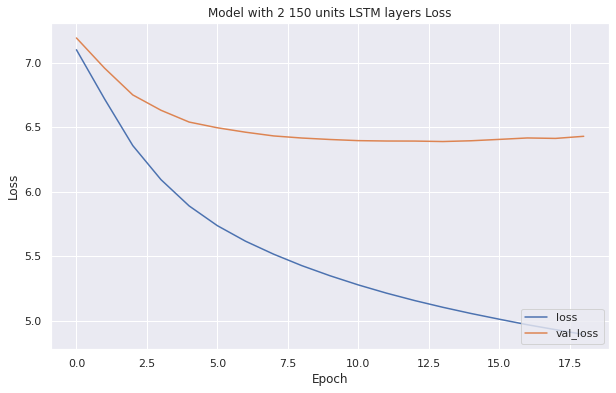

    9/14385 [..............................] - ETA: 3:05 - loss: 5.6305 - sparse_categorical_accuracy: 0.2396

2022-04-16 21:31:05.751376: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 366412332 exceeds 10% of free system memory.


14385/14385 [==============================] - 142s 10ms/step - loss: 5.9510 - sparse_categorical_accuracy: 0.2160
Model accuracy: 0.2159794270992279


In [19]:
params = [(2, 150, 0.2), (3, 150, 0.2), (2, 64, 0.2)]
model, param = get_best_model(params)

Plot the architecture of the best model

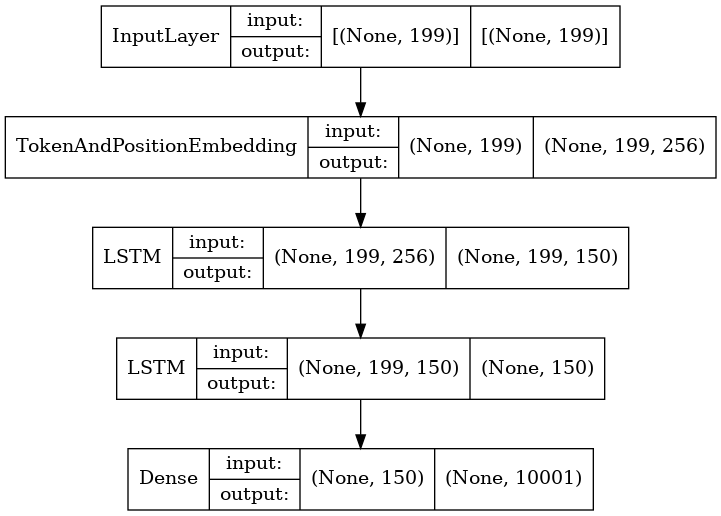

In [10]:
plot_model(model, to_file=str(plot_dir / "model-2-150.png"), show_layer_names=False, show_shapes=True)

Get best model parameters

In [26]:
print(param)

(2, 150, 0.2)


## Visualize Word Embeddings

Load weight and vocab

In [31]:
import io
weights = model.get_layer('token_and_position_embedding').get_weights()[0]
vocab = tokenizer.word_index

Write the weights to disk. To use the Embedding Projector, we need to upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [32]:
out_v = io.open(model_home / 'vectors.tsv', 'w', encoding='utf-8')
out_m = io.open(model_home /'metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab.keys()):
    if index < 2:
        continue  # skip 0, it's padding.
    if index > 10000:
        break
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

## Testing the model with actual data

Load model and tokenizer from directory

In [20]:
model_saved_dir = model_home / 'model-2-150'
model = tf.keras.models.load_model(model_saved_dir)

with open(model_home / 'tokenizer_10000_words.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

`predict_next_words` function takes model, tokenizer and text as function argument and returns top 5 next words predicted by the model

In [21]:
def predict_next_words(model, tokenizer, text):
    # tokenize the text
    tokenized_sequence = tokenizer.texts_to_sequences([text])
    # pre-pad with 0's to make it of size MAX_SEQUENCE_LENGTH - 1
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequence,
                                                                maxlen=max_seq_len - 1,
                                                                padding='pre')
    # predict using model
    predictions = model.predict(input_sequences)
    ids = np.argsort(predictions, axis=1)[:, -5:] # indices of the top 5 predictions
    # print next word with score
    for id in ids[0]:
        print(tokenizer.index_word[id], "->", predictions[:, id].squeeze())

Test for custom texts by calling the function

In [22]:
text = input("Enter text: ")
predict_next_words(model, tokenizer, text)

Enter text: কেন
২ -> 0.010123348
এই -> 0.01702388
আমার -> 0.0277904
আমি -> 0.045058608
<oov> -> 0.21097933


## Convert Keras model to TensorFlow Lite model

Fix input size for the model

In [23]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
INPUT_SIZE = 199
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
model.save(model_saved_dir, save_format="tf", signatures=concrete_func)

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150/assets


Convert the model to Tensorflow Lite

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(str(model_saved_dir))
converter.experimental_new_converter = True
tflite_model = converter.convert()

2022-04-16 21:34:29.655793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-16 21:34:29.655834: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-16 21:34:29.668771: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150
2022-04-16 21:34:29.687497: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-16 21:34:29.687781: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model-2-150
2022-04-16 21:34:29.744658: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-16 21:34:29.880406: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /home/shafquat/bangla-next-word-prediction/models/b

Save the converted tflite model to file

In [25]:
with open(model_home / 'bn_lstm.tflite', 'wb') as file_handle:
    file_handle.write(tflite_model)

Test the tflite converted model

In [26]:
interpreter = tf.lite.Interpreter(model_path=str(model_home / 'bn_lstm.tflite'))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Get prediction from the model

In [27]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.int32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.10251888e-08 7.95967430e-02 1.35746915e-02 ... 6.06659023e-06
  1.96055262e-04 1.01836104e-08]]


Check input and output shape

In [28]:
input_shape

array([  1, 199], dtype=int32)

In [29]:
output_data.shape

(1, 10001)